In [149]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
#import mpld3
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import filter_output_reader as freader
from importlib import reload

import scipy.stats as stats

%matplotlib inline

In [150]:
example_datafile = '../python/example_data.txt'
filter_config = '../cpp/connectivity.txt'
output_data = '../cpp/test_output.txt'

In [151]:
reload(freader)
dns_data = freader.read_dns_data(example_datafile)
nodes, conn = freader.read_filter_configuration(filter_config)
filter_result = freader.read_output_data(output_data)

Reading data from:   ../python/example_data.txt
Filter defined in:   connectivity.txt


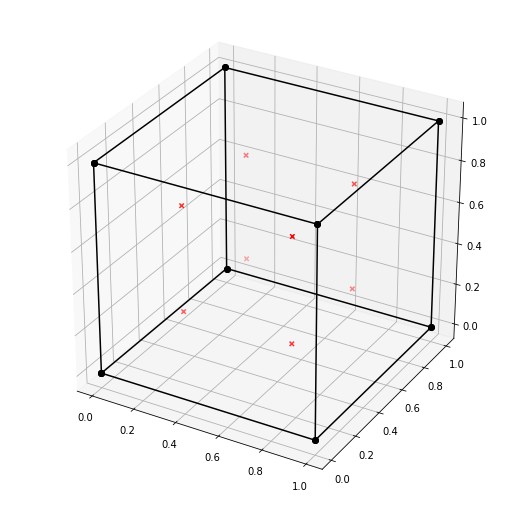

In [152]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
eid = 10
freader.plot_hex(10, nodes, conn, ax)
freader.plot_filter_cgs(eid, 0, filter_result, ax)

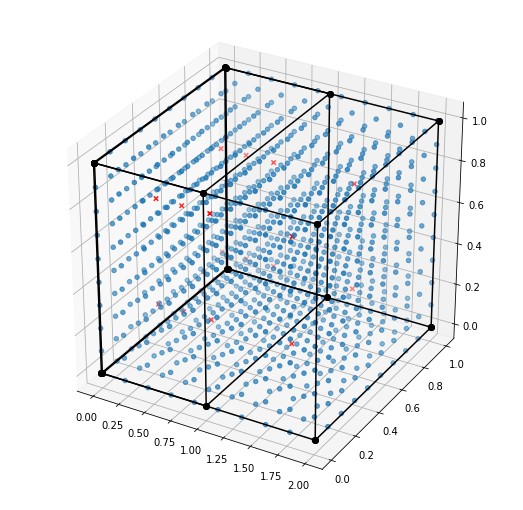

In [153]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

eid = 10
t = 0.0
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)

eid = 10
t = 1.0
ax.scatter(*zip(*dns_data[t]))
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)


In [154]:
tmp = filter_result[1][10].dof_values[0,3:]
print(filter_result[1][10].dof_values[1])


D = np.array([[tmp[0], tmp[5], tmp[4]],\
              [tmp[8], tmp[1], tmp[3]],\
              [tmp[7], tmp[6], tmp[2]]])

Csq = np.matmul(D.T, D)
Csq

[ 1.00910e+00  1.16287e-17  1.30184e-17  1.04972e+00 -7.92969e-16
 -9.91467e-17 -1.21430e-15  1.64372e-15  4.45824e-15 -6.49909e-16
 -6.07988e-16 -5.45729e-16]


array([[ 1.10191208e+00, -7.52959957e-15, -5.65362396e-15],
       [-7.52959957e-15,  5.91182602e-29,  4.65024817e-29],
       [-5.65362396e-15,  4.65024817e-29,  4.13702868e-29]])

In [155]:
np.random.seed(123)
X = np.random.rand(9).reshape((3, 3))
print("X:\n",X)
A = X.dot(X)
print("A:\n",A)
Av = to_voigt(A)
#print(A[[0,0]])
#print('mat sqrt')

Xs = freader.matsqrt(A)
np.allclose(Xs.dot(Xs), A)

X:
 [[0.69646919 0.28613933 0.22685145]
 [0.55131477 0.71946897 0.42310646]
 [0.9807642  0.68482974 0.4809319 ]]
A:
 [[0.86530995 0.56051022 0.38816255]
 [1.19559529 0.96514433 0.63296392]
 [1.53230958 1.10270543 0.74353916]]


True

In [156]:
A = X.T.dot(X)
print(A, np.linalg.matrix_rank(A))
Xs = freader.matsqrt(A, mode=2)
np.allclose(Xs.T.dot(Xs), A)

[[1.75091571 1.26759759 0.86294068]
 [1.26759759 1.06850309 0.69867956]
 [0.86294068 0.69867956 0.46177615]] 3


True

In [157]:
A = X.dot(X.T)
print(A, np.linalg.matrix_rank(A))
Xs = freader.matsqrt(A, mode=3)
np.allclose(Xs.dot(Xs.T), A)

[[0.61840663 0.68582444 0.98812887]
 [0.68582444 1.00060265 1.23690893]
 [0.98812887 1.23690893 1.66218568]] 3


True

In [158]:
freader.matsqrt(Csq, mode=2)

array([[ 1.04972000e+00, -7.17275147e-15, -5.38568342e-15],
       [-7.17275147e-15,  3.05175781e-05,  8.59989175e-26],
       [-5.38568342e-15,  8.59989175e-26,  3.05175781e-05]])

In [159]:
Csq

array([[ 1.10191208e+00, -7.52959957e-15, -5.65362396e-15],
       [-7.52959957e-15,  5.91182602e-29,  4.65024817e-29],
       [-5.65362396e-15,  4.65024817e-29,  4.13702868e-29]])

In [160]:
D = np.array([[ 0.0897818,  -0.08773222, -0.0475752 ],
 [ 0.13518974, -0.05267145, -0.18058612],
 [ 0.06726339,  0.13142177, -0.0275545 ]]) + np.eye(3)

D.T.dot(D)

array([[ 1.210425  ,  0.0413    , -0.01085   ],
       [ 0.0413    ,  0.92240001, -0.0391    ],
       [-0.01085   , -0.0391    ,  0.980525  ]])

In [161]:
Q = np.array([[ 0.99255943, -0.11301034, -0.04532587],
 [ 0.1043222,   0.98125094, -0.16206009],
 [ 0.06279052,  0.15612578,  0.98573936]])
np.matmul(Q.T, Q)

array([[ 9.99999993e-01, -2.93003260e-09,  2.18641510e-09],
       [-2.93003260e-09,  1.00000000e+00,  2.78721198e-09],
       [ 2.18641510e-09,  2.78721198e-09,  9.99999993e-01]])

In [162]:
C = np.array([[ 1.1,    0.02,  -0.005],
 [ 0.02,   0.96,  -0.02 ],
 [-0.005, -0.02,   0.99 ]])

E = C.T.dot(C)

In [163]:
Es = D.T.dot(D)

np.allclose(E, Es)

True

In [164]:
np.linalg.eig(E)

(array([1.21735825, 0.89936105, 0.9966307 ]),
 array([[ 0.98663521,  0.10501586,  0.12458989],
        [ 0.14736543, -0.90134534, -0.40725913],
        [-0.06952985, -0.42017644,  0.90477476]]))

In [165]:
np.linalg.eig(Es)

(array([1.21735825, 0.89936105, 0.9966307 ]),
 array([[ 0.98663521,  0.10501585,  0.12458988],
        [ 0.14736543, -0.90134533, -0.40725917],
        [-0.06952983, -0.42017648,  0.90477474]]))

In [166]:
filter_result[1][10]

MicromorphicFilterData:
 nodes:
   -0.0091 -0.0000 -0.0000
   +2.0091 +0.0000 +0.0000
   +2.0091 +1.0000 +0.0000
   -0.0091 +1.0000 -0.0000
   -0.0091 -0.0000 +1.0000
   +2.0091 +0.0000 +1.0000
   +2.0091 +1.0000 +1.0000
   -0.0091 +1.0000 +1.0000
 dof values:
   -0.0091 -0.0000 -0.0000 +1.0497 +0.0000 +0.0000 +0.0000 -0.0000 -0.0000 +0.0000 +0.0000 +0.0000
   +1.0091 +0.0000 +0.0000 +1.0497 -0.0000 -0.0000 -0.0000 +0.0000 +0.0000 -0.0000 -0.0000 -0.0000
   +1.0091 +0.0000 +0.0000 +1.0497 +0.0000 +0.0000 +0.0000 -0.0000 -0.0000 +0.0000 +0.0000 +0.0000
   -0.0091 +0.0000 -0.0000 +1.0497 -0.0000 -0.0000 -0.0000 +0.0000 +0.0000 -0.0000 -0.0000 -0.0000
   -0.0091 -0.0000 +0.0000 +1.0497 +0.0000 -0.0000 -0.0000 +0.0000 +0.0000 -0.0000 -0.0000 +0.0000
   +1.0091 +0.0000 -0.0000 +1.0497 -0.0000 +0.0000 +0.0000 -0.0000 -0.0000 +0.0000 +0.0000 -0.0000
   +1.0091 -0.0000 -0.0000 +1.0497 +0.0000 -0.0000 -0.0000 +0.0000 -0.0000 -0.0000 -0.0000 +0.0000
   -0.0091 +0.0000 -0.0000 +1.0497 -0.0000 +0.


(u1, u2, u3, phi11, phi22, phi33, phi23, phi13, phi12, phi32, phi31, phi21)


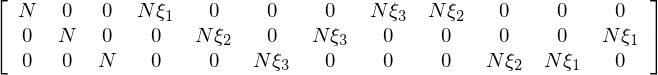

In [67]:
import sympy
sympy.init_session(quiet=True)

N = sympy.symbols("N")
us = sympy.symbols('u1 u2 u3')
phis = sympy.symbols('phi11 phi22 phi33 phi23 phi13 phi12 phi32 phi31 phi21')
xi = sympy.symbols('xi1 xi2 xi3')

vm = [(0, 0), (1, 1), (2, 2), (1, 2), (0, 2), (0, 1), (2, 1), (2, 0), (1, 0)]

phi = [None for _ in range(3)]
for i in range(3):
    phi[i] = [None for _ in range(3)]

for i, indx in enumerate(vm):
    phi[indx[0]][indx[1]] = phis[i]
    
phi

zero = sympy.S(0)
up = [zero for _ in range(3)]
for i in range(3):
    up[i] += N*us[i]
    
    for j in range(3):
        up[i] += N*phi[i][j]*xi[j]
        
up

M = [[zero for _ in range(12)] for __ in range(3)]

dof = us + phis
print(dof)

for i in range(3):
    for j in range(12):
        M[i][j] = sympy.diff(up[i], dof[j])
        
sympy.Matrix(M)

In [77]:
Xi = np.array([-0.194444, 0.194444, -0.25])
xi = np.array([-0.393339, 0.194444, -0.25])
xi/Xi

chi = np.eye(3) + np.array([[1, 0, 0],\
                            [0, 0, 0],\
                            [0, 0, 0]])
chi.dot(Xi)
print(xi, chi.dot(Xi))

phi_ = filter_result[1][10].dof_values[0, 3:]

phi = np.array([[phi_[0], phi_[5], phi_[4]],\
                [phi_[8], phi_[1], phi_[3]],\
                [phi_[7], phi_[6], phi_[2]]])
print(xi, (np.eye(3) + phi).dot(Xi))

[-0.393339  0.194444 -0.25    ] [-0.388888  0.194444 -0.25    ]
[-0.393339  0.194444 -0.25    ] [-0.39855576  0.194444   -0.25      ]


In [78]:
np.array([0.5555555555555556, 0.4444444444444444, 0.0]) - np.array([0.75, 0.25, 0.25])

array([-0.19444444,  0.19444444, -0.25      ])

In [103]:
p_450 = np.array([np.array([0.5555555555555556, 0.4444444444444444, 0.0]),
np.array([0.6111111111111112, 0.4444444444444444, 0.0]),
np.array([0.6666666666666666, 0.4444444444444444, 0.0]),
np.array([0.7222222222222223, 0.4444444444444444, 0.0]),
np.array([0.7777777777777778, 0.4444444444444444, 0.0]),
np.array([0.8333333333333334, 0.4444444444444444, 0.0]),
np.array([0.888888888888889, 0.4444444444444444, 0.0]),
np.array([ 0.9444444444444445, 0.4444444444444444, 0.0]),
np.array([1.0, 0.4444444444444444, 0.0]),
np.array([1.0555555555555556, 0.4444444444444444, 0.0]),
np.array([1.1111111111111112, 0.4444444444444444, 0.0])])
p_450

array([[0.55555556, 0.44444444, 0.        ],
       [0.61111111, 0.44444444, 0.        ],
       [0.66666667, 0.44444444, 0.        ],
       [0.72222222, 0.44444444, 0.        ],
       [0.77777778, 0.44444444, 0.        ],
       [0.83333333, 0.44444444, 0.        ],
       [0.88888889, 0.44444444, 0.        ],
       [0.94444444, 0.44444444, 0.        ],
       [1.        , 0.44444444, 0.        ],
       [1.05555556, 0.44444444, 0.        ],
       [1.11111111, 0.44444444, 0.        ]])

In [104]:
u_450 = p_450 - p_450[0]
u_450

array([[0.        , 0.        , 0.        ],
       [0.05555556, 0.        , 0.        ],
       [0.11111111, 0.        , 0.        ],
       [0.16666667, 0.        , 0.        ],
       [0.22222222, 0.        , 0.        ],
       [0.27777778, 0.        , 0.        ],
       [0.33333333, 0.        , 0.        ],
       [0.38888889, 0.        , 0.        ],
       [0.44444444, 0.        , 0.        ],
       [0.5       , 0.        , 0.        ],
       [0.55555556, 0.        , 0.        ]])

In [87]:
cg_0 = np.array([0.75, 0.25, 0.25])
cg_450 = []
for t in np.linspace(0, 1, 11):
    cg_450.append((np.eye(3) + t*np.array([[1, 0, 0],
                                           [0, 0, 0],
                                           [0, 0, 0]])).dot(cg_0))
print(np.array(cg_450))

[[0.75  0.25  0.25 ]
 [0.825 0.25  0.25 ]
 [0.9   0.25  0.25 ]
 [0.975 0.25  0.25 ]
 [1.05  0.25  0.25 ]
 [1.125 0.25  0.25 ]
 [1.2   0.25  0.25 ]
 [1.275 0.25  0.25 ]
 [1.35  0.25  0.25 ]
 [1.425 0.25  0.25 ]
 [1.5   0.25  0.25 ]]


In [89]:
xi_450 = p_450 - cg_450
xi_450

array([[-0.19444444,  0.19444444, -0.25      ],
       [-0.21388889,  0.19444444, -0.25      ],
       [-0.23333333,  0.19444444, -0.25      ],
       [-0.25277778,  0.19444444, -0.25      ],
       [-0.27222222,  0.19444444, -0.25      ],
       [-0.29166667,  0.19444444, -0.25      ],
       [-0.31111111,  0.19444444, -0.25      ],
       [-0.33055556,  0.19444444, -0.25      ],
       [-0.35      ,  0.19444444, -0.25      ],
       [-0.36944444,  0.19444444, -0.25      ],
       [-0.38888889,  0.19444444, -0.25      ]])

In [102]:
filter_result[0][10].gauss_point_info.global_mass_center[0][0]